# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

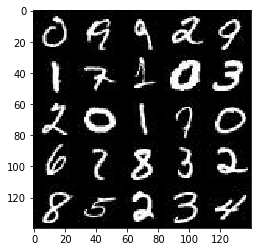

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

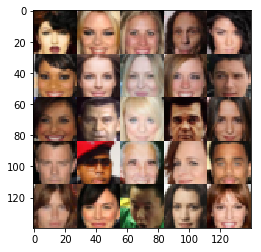

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [23]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer
        #should start with size same as image: 28x28x3
        #1st conv layer
        #add kernal_initializer=tf.contrib.layers.xavier_initializer() to conv2d to normalize each conv2d layer's initialization
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x64 now

        #2nd conv layer
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128 now
        
        #3rd conv layer
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # 4x4x256 now

        #add dropout layer to improve training result
        x3 = tf.nn.dropout(x3, 0.8)
        
        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        
        #output layer
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [24]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer with z input
        #should carry the same size as discriminator's output 
        #z = tf.nn.dropout(z, 0.8)
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional layer
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now

        # 2nd conv layer
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        # 3rd conv layer
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x64 now
        
        #add dropout
        x3 = tf.nn.dropout(x3, 0.8)
        
        # use strides 1 to keep this layer at same heightxwidth at 28x28
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28xout_channel_dim now
        
        #Output layer        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    #calcalute loss using reduce_mean on sigmoid_cross_entropy_with_logits between logits and labels
    # discriminator real wants labels of 1's
    # discriminator fake wants labels of 0's
    # generator's  fake wants labels of 1's to fool discriminator
    
    #add smoothing of 0.1 to 
    smooth = 0.1

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
       
    #print('data_shape={}',format(data_shape))
    #print('z_dim={}',format(z_dim))
    # TODO: Build Model
    input_real, input_z, _ = model_inputs(image_width=data_shape[1],
                                       image_height=data_shape[2],
                                       image_channels=data_shape[3],
                                       z_dim=z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim=data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
        
    
    #saver = tf.train.Saver()
    num_sample_image = 20
    #sample_z = np.random.uniform(-1, 1, size=(num_sample_image, z_dim))
    sample_z = tf.random_uniform((num_sample_image, z_dim))

    #print("sample_z.get_shape={}",format(sample_z.get_shape()))
    
    steps = 0
    print_every = 10
    show_every = 100
    
    #start a session to train model with feed_dict to inputs
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #batch_z = tf.random_uniform((batch_size, z_dim))
                
                #multiply batch_images by 2 to normalize images to be same as generator
                batch_images *= 2

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{} steps {}...".format(epoch_i+1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess=sess, n_images=num_sample_image, input_z=sample_z, out_channel_dim=data_shape[3], image_mode=data_image_mode)
    
        print("end of loop")
        #saver.save(sess, 'generator.ckpt')

    print("about to exit train()")
    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/1 steps 10... Discriminator Loss: 0.5086... Generator Loss: 7.5474
Epoch 1/1 steps 20... Discriminator Loss: 6.3558... Generator Loss: 0.0120
Epoch 1/1 steps 30... Discriminator Loss: 0.4329... Generator Loss: 4.8705
Epoch 1/1 steps 40... Discriminator Loss: 0.4962... Generator Loss: 2.3940
Epoch 1/1 steps 50... Discriminator Loss: 4.8047... Generator Loss: 0.2081
Epoch 1/1 steps 60... Discriminator Loss: 0.6468... Generator Loss: 1.8447
Epoch 1/1 steps 70... Discriminator Loss: 0.4570... Generator Loss: 3.0821
Epoch 1/1 steps 80... Discriminator Loss: 0.5897... Generator Loss: 2.1363
Epoch 1/1 steps 90... Discriminator Loss: 1.2998... Generator Loss: 0.7524
Epoch 1/1 steps 100... Discriminator Loss: 1.4457... Generator Loss: 0.5459


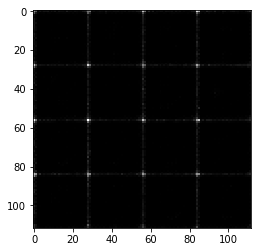

Epoch 1/1 steps 110... Discriminator Loss: 1.2446... Generator Loss: 0.6478
Epoch 1/1 steps 120... Discriminator Loss: 1.0331... Generator Loss: 1.2268
Epoch 1/1 steps 130... Discriminator Loss: 1.2419... Generator Loss: 0.8077
Epoch 1/1 steps 140... Discriminator Loss: 1.4025... Generator Loss: 0.5768
Epoch 1/1 steps 150... Discriminator Loss: 1.0755... Generator Loss: 1.1667
Epoch 1/1 steps 160... Discriminator Loss: 1.5002... Generator Loss: 0.5207
Epoch 1/1 steps 170... Discriminator Loss: 1.5027... Generator Loss: 0.5554
Epoch 1/1 steps 180... Discriminator Loss: 1.1228... Generator Loss: 2.0631
Epoch 1/1 steps 190... Discriminator Loss: 1.0112... Generator Loss: 1.6283
Epoch 1/1 steps 200... Discriminator Loss: 0.9325... Generator Loss: 1.0922


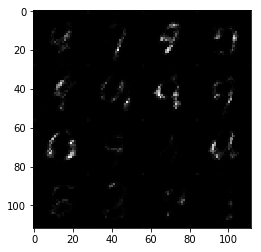

Epoch 1/1 steps 210... Discriminator Loss: 0.9975... Generator Loss: 1.7071
Epoch 1/1 steps 220... Discriminator Loss: 0.9336... Generator Loss: 1.3051
Epoch 1/1 steps 230... Discriminator Loss: 1.2092... Generator Loss: 0.8437
Epoch 1/1 steps 240... Discriminator Loss: 1.2285... Generator Loss: 1.8228
Epoch 1/1 steps 250... Discriminator Loss: 1.1103... Generator Loss: 1.0841
Epoch 1/1 steps 260... Discriminator Loss: 1.2884... Generator Loss: 0.7761
Epoch 1/1 steps 270... Discriminator Loss: 0.9858... Generator Loss: 1.2836
Epoch 1/1 steps 280... Discriminator Loss: 1.0641... Generator Loss: 1.0758
Epoch 1/1 steps 290... Discriminator Loss: 1.0916... Generator Loss: 0.9090
Epoch 1/1 steps 300... Discriminator Loss: 1.0929... Generator Loss: 0.7884


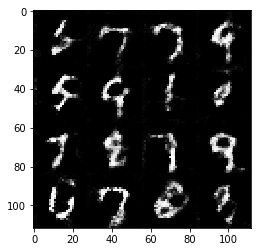

Epoch 1/1 steps 310... Discriminator Loss: 1.3874... Generator Loss: 0.6238
Epoch 1/1 steps 320... Discriminator Loss: 1.2013... Generator Loss: 1.8109
Epoch 1/1 steps 330... Discriminator Loss: 1.0774... Generator Loss: 1.5122
Epoch 1/1 steps 340... Discriminator Loss: 1.1640... Generator Loss: 0.9398
Epoch 1/1 steps 350... Discriminator Loss: 1.0720... Generator Loss: 0.9154
Epoch 1/1 steps 360... Discriminator Loss: 1.1345... Generator Loss: 0.9966
Epoch 1/1 steps 370... Discriminator Loss: 1.2971... Generator Loss: 0.7665
Epoch 1/1 steps 380... Discriminator Loss: 1.1675... Generator Loss: 0.9516
Epoch 1/1 steps 390... Discriminator Loss: 1.0168... Generator Loss: 1.3764
Epoch 1/1 steps 400... Discriminator Loss: 1.0651... Generator Loss: 1.5625


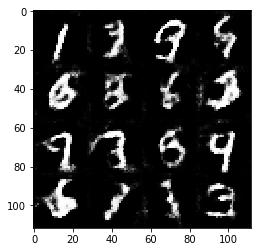

Epoch 1/1 steps 410... Discriminator Loss: 1.1119... Generator Loss: 0.8039
Epoch 1/1 steps 420... Discriminator Loss: 1.1152... Generator Loss: 0.9736
Epoch 1/1 steps 430... Discriminator Loss: 0.9795... Generator Loss: 1.3611
Epoch 1/1 steps 440... Discriminator Loss: 1.1860... Generator Loss: 0.8036
Epoch 1/1 steps 450... Discriminator Loss: 1.1835... Generator Loss: 1.1758
Epoch 1/1 steps 460... Discriminator Loss: 1.0801... Generator Loss: 1.1893
Epoch 1/1 steps 470... Discriminator Loss: 1.1242... Generator Loss: 1.0816
Epoch 1/1 steps 480... Discriminator Loss: 1.1482... Generator Loss: 1.0793
Epoch 1/1 steps 490... Discriminator Loss: 1.0382... Generator Loss: 1.0328
Epoch 1/1 steps 500... Discriminator Loss: 1.0497... Generator Loss: 1.6361


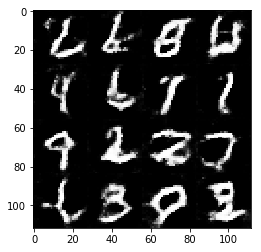

Epoch 1/1 steps 510... Discriminator Loss: 1.0696... Generator Loss: 1.0321
Epoch 1/1 steps 520... Discriminator Loss: 1.2028... Generator Loss: 2.2695
Epoch 1/1 steps 530... Discriminator Loss: 1.0737... Generator Loss: 1.1419
Epoch 1/1 steps 540... Discriminator Loss: 1.0441... Generator Loss: 1.6098
Epoch 1/1 steps 550... Discriminator Loss: 1.1281... Generator Loss: 1.4043
Epoch 1/1 steps 560... Discriminator Loss: 0.9693... Generator Loss: 1.5036
Epoch 1/1 steps 570... Discriminator Loss: 1.0333... Generator Loss: 1.2726
Epoch 1/1 steps 580... Discriminator Loss: 0.9728... Generator Loss: 1.4309
Epoch 1/1 steps 590... Discriminator Loss: 1.4412... Generator Loss: 0.5669
Epoch 1/1 steps 600... Discriminator Loss: 1.0669... Generator Loss: 1.0983


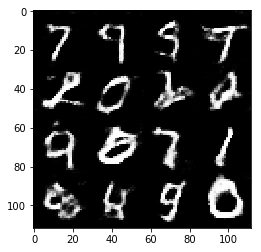

Epoch 1/1 steps 610... Discriminator Loss: 1.1518... Generator Loss: 0.7570
Epoch 1/1 steps 620... Discriminator Loss: 1.1518... Generator Loss: 0.7219
Epoch 1/1 steps 630... Discriminator Loss: 1.1051... Generator Loss: 1.0148
Epoch 1/1 steps 640... Discriminator Loss: 1.0638... Generator Loss: 1.3885
Epoch 1/1 steps 650... Discriminator Loss: 1.3406... Generator Loss: 0.5971
Epoch 1/1 steps 660... Discriminator Loss: 0.9251... Generator Loss: 1.1322
Epoch 1/1 steps 670... Discriminator Loss: 1.1446... Generator Loss: 0.8216
Epoch 1/1 steps 680... Discriminator Loss: 1.7068... Generator Loss: 0.4363
Epoch 1/1 steps 690... Discriminator Loss: 0.9613... Generator Loss: 1.0743
Epoch 1/1 steps 700... Discriminator Loss: 1.0355... Generator Loss: 1.3819


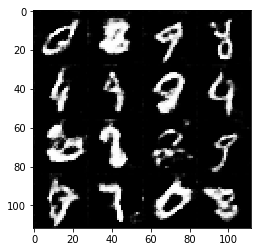

Epoch 1/1 steps 710... Discriminator Loss: 0.9772... Generator Loss: 1.1760
Epoch 1/1 steps 720... Discriminator Loss: 1.0951... Generator Loss: 0.9411
Epoch 1/1 steps 730... Discriminator Loss: 0.9753... Generator Loss: 1.3287
Epoch 1/1 steps 740... Discriminator Loss: 1.1836... Generator Loss: 1.6192
Epoch 1/1 steps 750... Discriminator Loss: 1.0736... Generator Loss: 1.1620
Epoch 1/1 steps 760... Discriminator Loss: 1.1441... Generator Loss: 0.9681
Epoch 1/1 steps 770... Discriminator Loss: 0.9371... Generator Loss: 1.7269
Epoch 1/1 steps 780... Discriminator Loss: 1.6917... Generator Loss: 0.4243
Epoch 1/1 steps 790... Discriminator Loss: 1.2738... Generator Loss: 0.6870
Epoch 1/1 steps 800... Discriminator Loss: 0.9032... Generator Loss: 1.4519


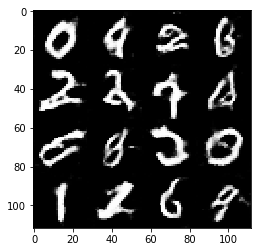

Epoch 1/1 steps 810... Discriminator Loss: 1.4747... Generator Loss: 2.5129
Epoch 1/1 steps 820... Discriminator Loss: 1.1295... Generator Loss: 0.9437
Epoch 1/1 steps 830... Discriminator Loss: 1.1854... Generator Loss: 0.6868
Epoch 1/1 steps 840... Discriminator Loss: 1.0714... Generator Loss: 0.9279
Epoch 1/1 steps 850... Discriminator Loss: 1.2739... Generator Loss: 0.7272
Epoch 1/1 steps 860... Discriminator Loss: 0.9765... Generator Loss: 1.1885
Epoch 1/1 steps 870... Discriminator Loss: 0.9951... Generator Loss: 1.2583
Epoch 1/1 steps 880... Discriminator Loss: 0.8629... Generator Loss: 1.4999
Epoch 1/1 steps 890... Discriminator Loss: 1.1527... Generator Loss: 0.8424
Epoch 1/1 steps 900... Discriminator Loss: 0.9603... Generator Loss: 1.4072


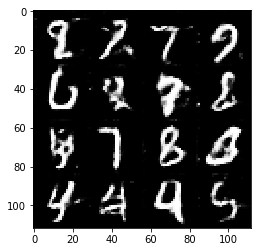

Epoch 1/1 steps 910... Discriminator Loss: 1.1206... Generator Loss: 0.8945
Epoch 1/1 steps 920... Discriminator Loss: 1.1972... Generator Loss: 0.7344
Epoch 1/1 steps 930... Discriminator Loss: 1.1956... Generator Loss: 1.1448
end of loop
about to exit train()
done training mnist
done-tf.graph
done mnist_dataset (60000, 28, 28, 1)L


In [26]:
'''
batch_size = 64
z_dim = 100
learning_rate = 0.01
beta1 = 0.3

result
Epoch 2/2 steps 1870... Discriminator Loss: 0.3786... Generator Loss: 1.5388
'''

batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
    print("done training mnist")
print("done-tf.graph")

print("done mnist_dataset {}{}".format(mnist_dataset.shape, mnist_dataset.image_mode))


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2 steps 10... Discriminator Loss: 0.5131... Generator Loss: 3.1131
Epoch 1/2 steps 20... Discriminator Loss: 0.5529... Generator Loss: 4.0303
Epoch 1/2 steps 30... Discriminator Loss: 0.9255... Generator Loss: 6.7607
Epoch 1/2 steps 40... Discriminator Loss: 0.9833... Generator Loss: 4.0188
Epoch 1/2 steps 50... Discriminator Loss: 0.5433... Generator Loss: 3.6141
Epoch 1/2 steps 60... Discriminator Loss: 0.5127... Generator Loss: 2.5883
Epoch 1/2 steps 70... Discriminator Loss: 0.4690... Generator Loss: 3.3580
Epoch 1/2 steps 80... Discriminator Loss: 0.4613... Generator Loss: 2.9880
Epoch 1/2 steps 90... Discriminator Loss: 0.4372... Generator Loss: 3.0385
Epoch 1/2 steps 100... Discriminator Loss: 0.7754... Generator Loss: 1.7559


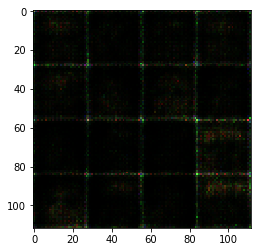

Epoch 1/2 steps 110... Discriminator Loss: 0.4964... Generator Loss: 2.6124
Epoch 1/2 steps 120... Discriminator Loss: 0.4340... Generator Loss: 2.8371
Epoch 1/2 steps 130... Discriminator Loss: 0.4048... Generator Loss: 3.3618
Epoch 1/2 steps 140... Discriminator Loss: 0.4296... Generator Loss: 3.0695
Epoch 1/2 steps 150... Discriminator Loss: 1.3245... Generator Loss: 0.7290
Epoch 1/2 steps 160... Discriminator Loss: 0.6426... Generator Loss: 1.6341
Epoch 1/2 steps 170... Discriminator Loss: 0.7420... Generator Loss: 1.4772
Epoch 1/2 steps 180... Discriminator Loss: 0.6311... Generator Loss: 1.7111
Epoch 1/2 steps 190... Discriminator Loss: 0.6000... Generator Loss: 2.2673
Epoch 1/2 steps 200... Discriminator Loss: 0.5749... Generator Loss: 2.7214


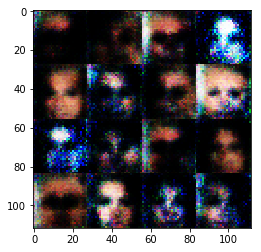

Epoch 1/2 steps 210... Discriminator Loss: 1.2081... Generator Loss: 4.5066
Epoch 1/2 steps 220... Discriminator Loss: 0.8576... Generator Loss: 1.4228
Epoch 1/2 steps 230... Discriminator Loss: 0.9693... Generator Loss: 0.9874
Epoch 1/2 steps 240... Discriminator Loss: 0.5353... Generator Loss: 2.3962
Epoch 1/2 steps 250... Discriminator Loss: 0.8104... Generator Loss: 3.4971
Epoch 1/2 steps 260... Discriminator Loss: 0.5867... Generator Loss: 2.9590
Epoch 1/2 steps 270... Discriminator Loss: 0.5153... Generator Loss: 2.2725
Epoch 1/2 steps 280... Discriminator Loss: 1.1280... Generator Loss: 5.6893
Epoch 1/2 steps 290... Discriminator Loss: 0.7648... Generator Loss: 3.1884
Epoch 1/2 steps 300... Discriminator Loss: 0.4620... Generator Loss: 3.2507


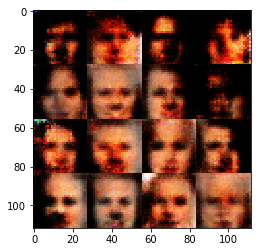

Epoch 1/2 steps 310... Discriminator Loss: 1.1518... Generator Loss: 0.8230
Epoch 1/2 steps 320... Discriminator Loss: 0.6825... Generator Loss: 3.4891
Epoch 1/2 steps 330... Discriminator Loss: 1.0503... Generator Loss: 0.9959
Epoch 1/2 steps 340... Discriminator Loss: 0.6042... Generator Loss: 1.9669
Epoch 1/2 steps 350... Discriminator Loss: 0.8798... Generator Loss: 1.1548
Epoch 1/2 steps 360... Discriminator Loss: 0.6779... Generator Loss: 2.5998
Epoch 1/2 steps 370... Discriminator Loss: 1.5190... Generator Loss: 5.0621
Epoch 1/2 steps 380... Discriminator Loss: 0.7616... Generator Loss: 3.1014
Epoch 1/2 steps 390... Discriminator Loss: 0.7248... Generator Loss: 2.4417
Epoch 1/2 steps 400... Discriminator Loss: 0.6854... Generator Loss: 1.9427


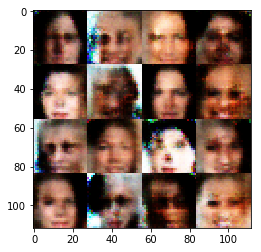

Epoch 1/2 steps 410... Discriminator Loss: 1.0493... Generator Loss: 1.0063
Epoch 1/2 steps 420... Discriminator Loss: 0.9943... Generator Loss: 1.1137
Epoch 1/2 steps 430... Discriminator Loss: 0.8600... Generator Loss: 1.5678
Epoch 1/2 steps 440... Discriminator Loss: 0.7696... Generator Loss: 1.9239
Epoch 1/2 steps 450... Discriminator Loss: 0.8462... Generator Loss: 2.0910
Epoch 1/2 steps 460... Discriminator Loss: 0.8718... Generator Loss: 1.5128
Epoch 1/2 steps 470... Discriminator Loss: 1.6603... Generator Loss: 3.8833
Epoch 1/2 steps 480... Discriminator Loss: 0.8354... Generator Loss: 2.0257
Epoch 1/2 steps 490... Discriminator Loss: 1.5426... Generator Loss: 3.6807
Epoch 1/2 steps 500... Discriminator Loss: 0.9069... Generator Loss: 1.0931


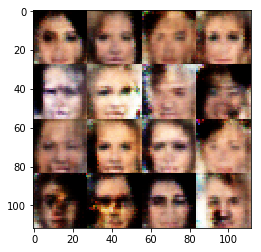

Epoch 1/2 steps 510... Discriminator Loss: 0.8955... Generator Loss: 1.3418
Epoch 1/2 steps 520... Discriminator Loss: 0.9950... Generator Loss: 0.9546
Epoch 1/2 steps 530... Discriminator Loss: 0.8643... Generator Loss: 1.0860
Epoch 1/2 steps 540... Discriminator Loss: 0.8099... Generator Loss: 2.3558
Epoch 1/2 steps 550... Discriminator Loss: 1.3432... Generator Loss: 0.5950
Epoch 1/2 steps 560... Discriminator Loss: 0.9681... Generator Loss: 0.9968
Epoch 1/2 steps 570... Discriminator Loss: 1.0018... Generator Loss: 0.9933
Epoch 1/2 steps 580... Discriminator Loss: 0.9398... Generator Loss: 1.4244
Epoch 1/2 steps 590... Discriminator Loss: 1.4044... Generator Loss: 3.3481
Epoch 1/2 steps 600... Discriminator Loss: 0.8781... Generator Loss: 2.2991


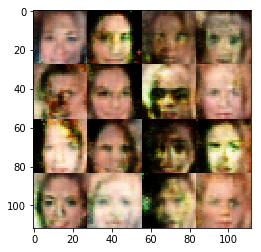

Epoch 1/2 steps 610... Discriminator Loss: 0.8441... Generator Loss: 2.0552
Epoch 1/2 steps 620... Discriminator Loss: 0.9514... Generator Loss: 1.4088
Epoch 1/2 steps 630... Discriminator Loss: 0.9557... Generator Loss: 0.9553
Epoch 1/2 steps 640... Discriminator Loss: 1.0265... Generator Loss: 0.8459
Epoch 1/2 steps 650... Discriminator Loss: 1.0341... Generator Loss: 2.0948
Epoch 1/2 steps 660... Discriminator Loss: 1.9634... Generator Loss: 0.2842
Epoch 1/2 steps 670... Discriminator Loss: 1.0453... Generator Loss: 0.8779
Epoch 1/2 steps 680... Discriminator Loss: 1.1570... Generator Loss: 0.7786
Epoch 1/2 steps 690... Discriminator Loss: 0.9317... Generator Loss: 1.0843
Epoch 1/2 steps 700... Discriminator Loss: 1.0895... Generator Loss: 0.9099


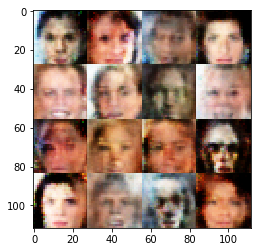

Epoch 1/2 steps 710... Discriminator Loss: 1.0020... Generator Loss: 1.0334
Epoch 1/2 steps 720... Discriminator Loss: 1.0466... Generator Loss: 0.9394
Epoch 1/2 steps 730... Discriminator Loss: 0.9681... Generator Loss: 1.4255
Epoch 1/2 steps 740... Discriminator Loss: 1.0448... Generator Loss: 2.4922
Epoch 1/2 steps 750... Discriminator Loss: 1.1016... Generator Loss: 1.3547
Epoch 1/2 steps 760... Discriminator Loss: 1.0072... Generator Loss: 1.6434
Epoch 1/2 steps 770... Discriminator Loss: 1.0495... Generator Loss: 2.2699
Epoch 1/2 steps 780... Discriminator Loss: 1.0624... Generator Loss: 1.0758
Epoch 1/2 steps 790... Discriminator Loss: 0.9076... Generator Loss: 1.4659
Epoch 1/2 steps 800... Discriminator Loss: 1.1029... Generator Loss: 1.7557


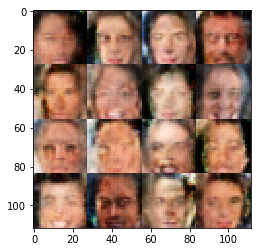

Epoch 1/2 steps 810... Discriminator Loss: 0.9894... Generator Loss: 1.0538
Epoch 1/2 steps 820... Discriminator Loss: 1.1703... Generator Loss: 1.3405
Epoch 1/2 steps 830... Discriminator Loss: 1.1312... Generator Loss: 1.0810
Epoch 1/2 steps 840... Discriminator Loss: 1.0071... Generator Loss: 0.9534
Epoch 1/2 steps 850... Discriminator Loss: 1.4599... Generator Loss: 0.5802
Epoch 1/2 steps 860... Discriminator Loss: 1.0577... Generator Loss: 2.0568
Epoch 1/2 steps 870... Discriminator Loss: 1.1102... Generator Loss: 1.3473
Epoch 1/2 steps 880... Discriminator Loss: 1.6423... Generator Loss: 0.3860
Epoch 1/2 steps 890... Discriminator Loss: 1.2467... Generator Loss: 0.7508
Epoch 1/2 steps 900... Discriminator Loss: 0.9649... Generator Loss: 1.4460


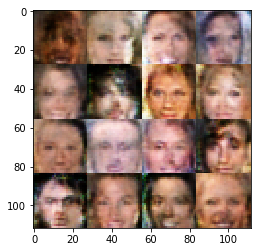

Epoch 1/2 steps 910... Discriminator Loss: 1.0225... Generator Loss: 1.1137
Epoch 1/2 steps 920... Discriminator Loss: 1.1312... Generator Loss: 1.1112
Epoch 1/2 steps 930... Discriminator Loss: 1.2138... Generator Loss: 0.8193
Epoch 1/2 steps 940... Discriminator Loss: 1.0250... Generator Loss: 1.4204
Epoch 1/2 steps 950... Discriminator Loss: 1.1269... Generator Loss: 0.8477
Epoch 1/2 steps 960... Discriminator Loss: 1.0731... Generator Loss: 1.0171
Epoch 1/2 steps 970... Discriminator Loss: 1.1968... Generator Loss: 0.8030
Epoch 1/2 steps 980... Discriminator Loss: 1.0161... Generator Loss: 1.1889
Epoch 1/2 steps 990... Discriminator Loss: 1.1147... Generator Loss: 0.9720
Epoch 1/2 steps 1000... Discriminator Loss: 0.8644... Generator Loss: 1.5596


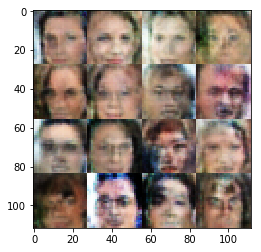

Epoch 1/2 steps 1010... Discriminator Loss: 1.1966... Generator Loss: 1.3185
Epoch 1/2 steps 1020... Discriminator Loss: 1.0498... Generator Loss: 1.1428
Epoch 1/2 steps 1030... Discriminator Loss: 0.9596... Generator Loss: 1.3379
Epoch 1/2 steps 1040... Discriminator Loss: 1.1046... Generator Loss: 1.2140
Epoch 1/2 steps 1050... Discriminator Loss: 1.2276... Generator Loss: 0.7373
Epoch 1/2 steps 1060... Discriminator Loss: 0.9831... Generator Loss: 1.1715
Epoch 1/2 steps 1070... Discriminator Loss: 1.2224... Generator Loss: 0.6726
Epoch 1/2 steps 1080... Discriminator Loss: 1.0354... Generator Loss: 1.1298
Epoch 1/2 steps 1090... Discriminator Loss: 1.1693... Generator Loss: 0.7730
Epoch 1/2 steps 1100... Discriminator Loss: 1.2128... Generator Loss: 0.6424


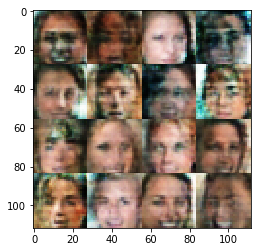

Epoch 1/2 steps 1110... Discriminator Loss: 1.1022... Generator Loss: 1.0592
Epoch 1/2 steps 1120... Discriminator Loss: 1.3049... Generator Loss: 0.7052
Epoch 1/2 steps 1130... Discriminator Loss: 1.1403... Generator Loss: 0.8769
Epoch 1/2 steps 1140... Discriminator Loss: 1.1544... Generator Loss: 1.1575
Epoch 1/2 steps 1150... Discriminator Loss: 1.0615... Generator Loss: 1.1597
Epoch 1/2 steps 1160... Discriminator Loss: 1.2480... Generator Loss: 0.7156
Epoch 1/2 steps 1170... Discriminator Loss: 1.0656... Generator Loss: 1.3811
Epoch 1/2 steps 1180... Discriminator Loss: 1.1252... Generator Loss: 0.8566
Epoch 1/2 steps 1190... Discriminator Loss: 1.1077... Generator Loss: 1.0854
Epoch 1/2 steps 1200... Discriminator Loss: 1.2680... Generator Loss: 0.7357


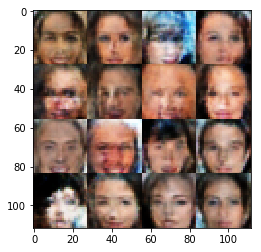

Epoch 1/2 steps 1210... Discriminator Loss: 1.7682... Generator Loss: 0.3793
Epoch 1/2 steps 1220... Discriminator Loss: 1.0529... Generator Loss: 1.6874
Epoch 1/2 steps 1230... Discriminator Loss: 1.0912... Generator Loss: 1.0988
Epoch 1/2 steps 1240... Discriminator Loss: 1.2376... Generator Loss: 1.0721
Epoch 1/2 steps 1250... Discriminator Loss: 1.1403... Generator Loss: 1.0361
Epoch 1/2 steps 1260... Discriminator Loss: 1.0332... Generator Loss: 0.9216
Epoch 1/2 steps 1270... Discriminator Loss: 1.1459... Generator Loss: 1.7306
Epoch 1/2 steps 1280... Discriminator Loss: 1.1884... Generator Loss: 0.8453
Epoch 1/2 steps 1290... Discriminator Loss: 1.3614... Generator Loss: 0.5622
Epoch 1/2 steps 1300... Discriminator Loss: 1.0019... Generator Loss: 1.2011


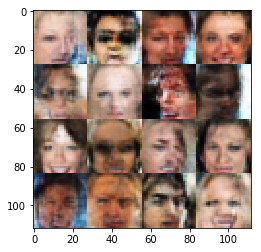

Epoch 1/2 steps 1310... Discriminator Loss: 1.0693... Generator Loss: 1.1553
Epoch 1/2 steps 1320... Discriminator Loss: 1.0929... Generator Loss: 1.0598
Epoch 1/2 steps 1330... Discriminator Loss: 1.1782... Generator Loss: 0.9190
Epoch 1/2 steps 1340... Discriminator Loss: 1.2060... Generator Loss: 0.7191
Epoch 1/2 steps 1350... Discriminator Loss: 1.0613... Generator Loss: 0.9525
Epoch 1/2 steps 1360... Discriminator Loss: 0.9805... Generator Loss: 1.4334
Epoch 1/2 steps 1370... Discriminator Loss: 1.0607... Generator Loss: 1.1576
Epoch 1/2 steps 1380... Discriminator Loss: 1.3449... Generator Loss: 0.5958
Epoch 1/2 steps 1390... Discriminator Loss: 1.0874... Generator Loss: 1.0077
Epoch 1/2 steps 1400... Discriminator Loss: 1.1576... Generator Loss: 0.7276


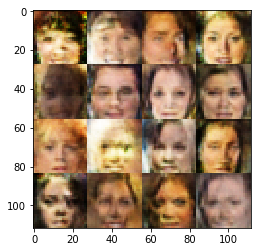

Epoch 1/2 steps 1410... Discriminator Loss: 1.1078... Generator Loss: 1.3388
Epoch 1/2 steps 1420... Discriminator Loss: 1.0609... Generator Loss: 0.9006
Epoch 1/2 steps 1430... Discriminator Loss: 1.1783... Generator Loss: 0.7523
Epoch 1/2 steps 1440... Discriminator Loss: 1.2325... Generator Loss: 0.8326
Epoch 1/2 steps 1450... Discriminator Loss: 1.1509... Generator Loss: 1.4281
Epoch 1/2 steps 1460... Discriminator Loss: 1.2041... Generator Loss: 1.4022
Epoch 1/2 steps 1470... Discriminator Loss: 1.1571... Generator Loss: 1.0004
Epoch 1/2 steps 1480... Discriminator Loss: 0.9884... Generator Loss: 1.2628
Epoch 1/2 steps 1490... Discriminator Loss: 1.0469... Generator Loss: 2.0110
Epoch 1/2 steps 1500... Discriminator Loss: 1.4629... Generator Loss: 0.9264


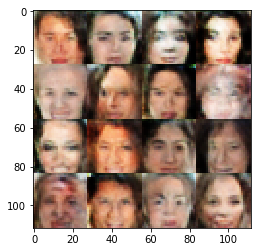

Epoch 1/2 steps 1510... Discriminator Loss: 1.1924... Generator Loss: 1.4207
Epoch 1/2 steps 1520... Discriminator Loss: 1.1754... Generator Loss: 0.8863
Epoch 1/2 steps 1530... Discriminator Loss: 1.3471... Generator Loss: 1.2029
Epoch 1/2 steps 1540... Discriminator Loss: 1.2635... Generator Loss: 0.7588
Epoch 1/2 steps 1550... Discriminator Loss: 1.1863... Generator Loss: 1.0038
Epoch 1/2 steps 1560... Discriminator Loss: 1.1080... Generator Loss: 0.8031
Epoch 1/2 steps 1570... Discriminator Loss: 1.1189... Generator Loss: 0.8487
Epoch 1/2 steps 1580... Discriminator Loss: 1.1266... Generator Loss: 0.9773
Epoch 1/2 steps 1590... Discriminator Loss: 1.2184... Generator Loss: 0.7432
Epoch 1/2 steps 1600... Discriminator Loss: 1.4623... Generator Loss: 1.0485


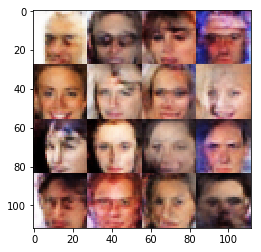

Epoch 1/2 steps 1610... Discriminator Loss: 1.1855... Generator Loss: 0.8075
Epoch 1/2 steps 1620... Discriminator Loss: 1.2081... Generator Loss: 0.7998
Epoch 1/2 steps 1630... Discriminator Loss: 1.0424... Generator Loss: 1.1374
Epoch 1/2 steps 1640... Discriminator Loss: 1.0847... Generator Loss: 0.9479
Epoch 1/2 steps 1650... Discriminator Loss: 1.3952... Generator Loss: 0.5795
Epoch 1/2 steps 1660... Discriminator Loss: 1.0278... Generator Loss: 1.0343
Epoch 1/2 steps 1670... Discriminator Loss: 0.9559... Generator Loss: 1.2502
Epoch 1/2 steps 1680... Discriminator Loss: 1.3886... Generator Loss: 0.5933
Epoch 1/2 steps 1690... Discriminator Loss: 1.0347... Generator Loss: 1.0780
Epoch 1/2 steps 1700... Discriminator Loss: 1.1128... Generator Loss: 0.9054


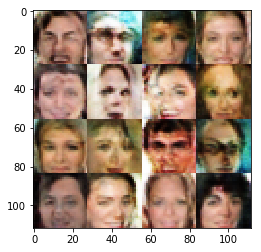

Epoch 1/2 steps 1710... Discriminator Loss: 1.1845... Generator Loss: 1.2457
Epoch 1/2 steps 1720... Discriminator Loss: 1.0532... Generator Loss: 1.1184
Epoch 1/2 steps 1730... Discriminator Loss: 1.1320... Generator Loss: 1.0476
Epoch 1/2 steps 1740... Discriminator Loss: 1.1256... Generator Loss: 1.0971
Epoch 1/2 steps 1750... Discriminator Loss: 1.2220... Generator Loss: 0.7711
Epoch 1/2 steps 1760... Discriminator Loss: 1.0495... Generator Loss: 0.9481
Epoch 1/2 steps 1770... Discriminator Loss: 1.2116... Generator Loss: 0.9097
Epoch 1/2 steps 1780... Discriminator Loss: 1.1018... Generator Loss: 1.0501
Epoch 1/2 steps 1790... Discriminator Loss: 1.2079... Generator Loss: 0.9313
Epoch 1/2 steps 1800... Discriminator Loss: 1.2646... Generator Loss: 0.6544


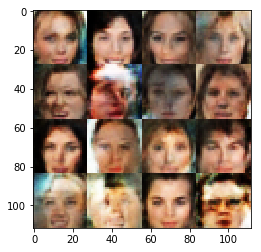

Epoch 1/2 steps 1810... Discriminator Loss: 1.2970... Generator Loss: 0.7850
Epoch 1/2 steps 1820... Discriminator Loss: 1.1718... Generator Loss: 0.9017
Epoch 1/2 steps 1830... Discriminator Loss: 1.0638... Generator Loss: 0.7863
Epoch 1/2 steps 1840... Discriminator Loss: 1.1322... Generator Loss: 1.4029
Epoch 1/2 steps 1850... Discriminator Loss: 1.0019... Generator Loss: 1.1209
Epoch 1/2 steps 1860... Discriminator Loss: 1.3539... Generator Loss: 0.5814
Epoch 1/2 steps 1870... Discriminator Loss: 1.2102... Generator Loss: 1.4101
Epoch 1/2 steps 1880... Discriminator Loss: 1.2674... Generator Loss: 0.8413
Epoch 1/2 steps 1890... Discriminator Loss: 1.2923... Generator Loss: 0.9176
Epoch 1/2 steps 1900... Discriminator Loss: 0.9942... Generator Loss: 0.9591


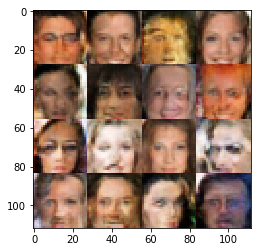

Epoch 1/2 steps 1910... Discriminator Loss: 1.2377... Generator Loss: 0.7063
Epoch 1/2 steps 1920... Discriminator Loss: 1.1338... Generator Loss: 0.9256
Epoch 1/2 steps 1930... Discriminator Loss: 1.0915... Generator Loss: 0.9252
Epoch 1/2 steps 1940... Discriminator Loss: 1.0950... Generator Loss: 1.5790
Epoch 1/2 steps 1950... Discriminator Loss: 1.1141... Generator Loss: 1.0603
Epoch 1/2 steps 1960... Discriminator Loss: 1.1536... Generator Loss: 1.1037
Epoch 1/2 steps 1970... Discriminator Loss: 1.1342... Generator Loss: 0.9767
Epoch 1/2 steps 1980... Discriminator Loss: 1.2031... Generator Loss: 1.0818
Epoch 1/2 steps 1990... Discriminator Loss: 1.3120... Generator Loss: 0.6474
Epoch 1/2 steps 2000... Discriminator Loss: 1.2199... Generator Loss: 0.9502


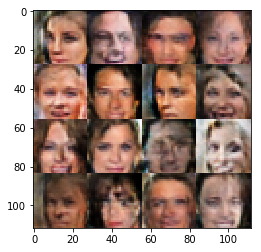

Epoch 1/2 steps 2010... Discriminator Loss: 1.0331... Generator Loss: 1.1459
Epoch 1/2 steps 2020... Discriminator Loss: 1.0712... Generator Loss: 1.6739
Epoch 1/2 steps 2030... Discriminator Loss: 1.2132... Generator Loss: 0.9043
Epoch 1/2 steps 2040... Discriminator Loss: 0.9801... Generator Loss: 2.0525
Epoch 1/2 steps 2050... Discriminator Loss: 1.3171... Generator Loss: 0.8864
Epoch 1/2 steps 2060... Discriminator Loss: 1.0447... Generator Loss: 1.3556
Epoch 1/2 steps 2070... Discriminator Loss: 1.1688... Generator Loss: 0.7180
Epoch 1/2 steps 2080... Discriminator Loss: 1.2365... Generator Loss: 1.0379
Epoch 1/2 steps 2090... Discriminator Loss: 1.2321... Generator Loss: 0.7709
Epoch 1/2 steps 2100... Discriminator Loss: 1.0516... Generator Loss: 1.1464


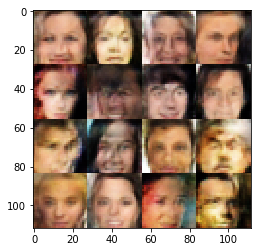

Epoch 1/2 steps 2110... Discriminator Loss: 1.1157... Generator Loss: 0.7682
Epoch 1/2 steps 2120... Discriminator Loss: 1.3842... Generator Loss: 0.5219
Epoch 1/2 steps 2130... Discriminator Loss: 0.8995... Generator Loss: 1.5301
Epoch 1/2 steps 2140... Discriminator Loss: 1.0879... Generator Loss: 1.0778
Epoch 1/2 steps 2150... Discriminator Loss: 1.0717... Generator Loss: 1.0427
Epoch 1/2 steps 2160... Discriminator Loss: 1.2267... Generator Loss: 0.7283
Epoch 1/2 steps 2170... Discriminator Loss: 0.9805... Generator Loss: 1.3470
Epoch 1/2 steps 2180... Discriminator Loss: 1.2451... Generator Loss: 0.8937
Epoch 1/2 steps 2190... Discriminator Loss: 1.3531... Generator Loss: 0.7645
Epoch 1/2 steps 2200... Discriminator Loss: 0.9764... Generator Loss: 1.3819


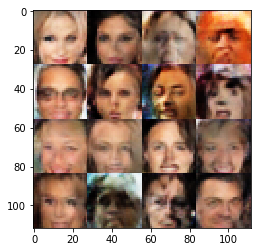

Epoch 1/2 steps 2210... Discriminator Loss: 1.1519... Generator Loss: 0.9838
Epoch 1/2 steps 2220... Discriminator Loss: 0.9801... Generator Loss: 0.9979
Epoch 1/2 steps 2230... Discriminator Loss: 1.0998... Generator Loss: 1.0486
Epoch 1/2 steps 2240... Discriminator Loss: 1.2416... Generator Loss: 0.8599
Epoch 1/2 steps 2250... Discriminator Loss: 1.2524... Generator Loss: 0.7803
Epoch 1/2 steps 2260... Discriminator Loss: 1.3252... Generator Loss: 0.6051
Epoch 1/2 steps 2270... Discriminator Loss: 0.9366... Generator Loss: 1.3504
Epoch 1/2 steps 2280... Discriminator Loss: 1.0328... Generator Loss: 0.9982
Epoch 1/2 steps 2290... Discriminator Loss: 1.2191... Generator Loss: 1.4418
Epoch 1/2 steps 2300... Discriminator Loss: 1.2566... Generator Loss: 0.8179


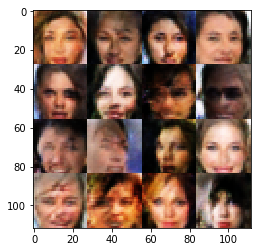

Epoch 1/2 steps 2310... Discriminator Loss: 1.0964... Generator Loss: 0.8338
Epoch 1/2 steps 2320... Discriminator Loss: 1.2555... Generator Loss: 0.6317
Epoch 1/2 steps 2330... Discriminator Loss: 1.1838... Generator Loss: 0.8774
Epoch 1/2 steps 2340... Discriminator Loss: 1.1983... Generator Loss: 1.6730
Epoch 1/2 steps 2350... Discriminator Loss: 1.0930... Generator Loss: 1.1233
Epoch 1/2 steps 2360... Discriminator Loss: 1.0139... Generator Loss: 1.0951
Epoch 1/2 steps 2370... Discriminator Loss: 1.2184... Generator Loss: 0.9196
Epoch 1/2 steps 2380... Discriminator Loss: 1.2962... Generator Loss: 0.6678
Epoch 1/2 steps 2390... Discriminator Loss: 1.2366... Generator Loss: 0.7106
Epoch 1/2 steps 2400... Discriminator Loss: 1.1951... Generator Loss: 0.9024


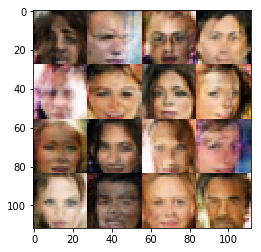

Epoch 1/2 steps 2410... Discriminator Loss: 1.1899... Generator Loss: 1.0431
Epoch 1/2 steps 2420... Discriminator Loss: 1.1746... Generator Loss: 0.9178
Epoch 1/2 steps 2430... Discriminator Loss: 1.1212... Generator Loss: 1.0182
Epoch 1/2 steps 2440... Discriminator Loss: 1.1572... Generator Loss: 0.8946
Epoch 1/2 steps 2450... Discriminator Loss: 1.2034... Generator Loss: 0.8528
Epoch 1/2 steps 2460... Discriminator Loss: 1.4460... Generator Loss: 0.4654
Epoch 1/2 steps 2470... Discriminator Loss: 1.3863... Generator Loss: 0.8380
Epoch 1/2 steps 2480... Discriminator Loss: 1.2652... Generator Loss: 0.7496
Epoch 1/2 steps 2490... Discriminator Loss: 1.1870... Generator Loss: 0.7940
Epoch 1/2 steps 2500... Discriminator Loss: 1.1986... Generator Loss: 1.2316


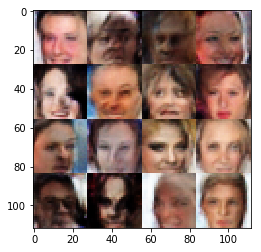

Epoch 1/2 steps 2510... Discriminator Loss: 1.2279... Generator Loss: 0.7351
Epoch 1/2 steps 2520... Discriminator Loss: 0.9955... Generator Loss: 1.3243
Epoch 1/2 steps 2530... Discriminator Loss: 1.6296... Generator Loss: 0.4030
Epoch 1/2 steps 2540... Discriminator Loss: 1.1152... Generator Loss: 1.1275
Epoch 1/2 steps 2550... Discriminator Loss: 1.0660... Generator Loss: 1.0649
Epoch 1/2 steps 2560... Discriminator Loss: 1.1967... Generator Loss: 1.3572
Epoch 1/2 steps 2570... Discriminator Loss: 1.3409... Generator Loss: 1.3102
Epoch 1/2 steps 2580... Discriminator Loss: 1.1334... Generator Loss: 0.9595
Epoch 1/2 steps 2590... Discriminator Loss: 1.2876... Generator Loss: 0.8026
Epoch 1/2 steps 2600... Discriminator Loss: 1.2169... Generator Loss: 1.1092


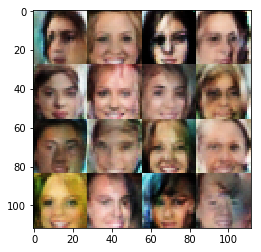

Epoch 1/2 steps 2610... Discriminator Loss: 1.1710... Generator Loss: 0.9715
Epoch 1/2 steps 2620... Discriminator Loss: 1.0980... Generator Loss: 1.0392
Epoch 1/2 steps 2630... Discriminator Loss: 1.5743... Generator Loss: 0.5201
Epoch 1/2 steps 2640... Discriminator Loss: 1.2710... Generator Loss: 0.6444
Epoch 1/2 steps 2650... Discriminator Loss: 1.1477... Generator Loss: 0.7797
Epoch 1/2 steps 2660... Discriminator Loss: 1.1830... Generator Loss: 1.1705
Epoch 1/2 steps 2670... Discriminator Loss: 1.1107... Generator Loss: 0.9837
Epoch 1/2 steps 2680... Discriminator Loss: 1.1880... Generator Loss: 1.0303
Epoch 1/2 steps 2690... Discriminator Loss: 1.2821... Generator Loss: 0.6599
Epoch 1/2 steps 2700... Discriminator Loss: 1.1285... Generator Loss: 0.9058


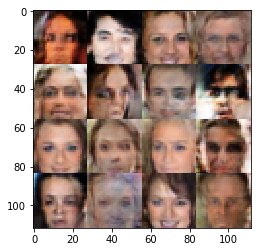

Epoch 1/2 steps 2710... Discriminator Loss: 1.0724... Generator Loss: 1.1783
Epoch 1/2 steps 2720... Discriminator Loss: 1.0197... Generator Loss: 1.1758
Epoch 1/2 steps 2730... Discriminator Loss: 1.2347... Generator Loss: 1.0311
Epoch 1/2 steps 2740... Discriminator Loss: 1.2001... Generator Loss: 0.6499
Epoch 1/2 steps 2750... Discriminator Loss: 1.1342... Generator Loss: 1.0599
Epoch 1/2 steps 2760... Discriminator Loss: 1.3498... Generator Loss: 0.6256
Epoch 1/2 steps 2770... Discriminator Loss: 1.0267... Generator Loss: 1.0459
Epoch 1/2 steps 2780... Discriminator Loss: 1.4087... Generator Loss: 0.6125
Epoch 1/2 steps 2790... Discriminator Loss: 0.9952... Generator Loss: 1.2738
Epoch 1/2 steps 2800... Discriminator Loss: 1.2778... Generator Loss: 0.6793


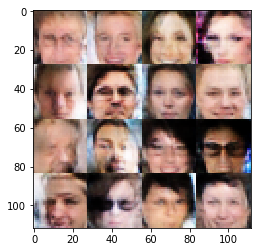

Epoch 1/2 steps 2810... Discriminator Loss: 1.1768... Generator Loss: 0.9331
Epoch 1/2 steps 2820... Discriminator Loss: 1.2804... Generator Loss: 0.6327
Epoch 1/2 steps 2830... Discriminator Loss: 1.0401... Generator Loss: 1.0873
Epoch 1/2 steps 2840... Discriminator Loss: 1.0853... Generator Loss: 1.2421
Epoch 1/2 steps 2850... Discriminator Loss: 1.2065... Generator Loss: 1.3255
Epoch 1/2 steps 2860... Discriminator Loss: 1.1319... Generator Loss: 1.4418
Epoch 1/2 steps 2870... Discriminator Loss: 1.2039... Generator Loss: 1.4225
Epoch 1/2 steps 2880... Discriminator Loss: 0.8933... Generator Loss: 1.3915
Epoch 1/2 steps 2890... Discriminator Loss: 1.1243... Generator Loss: 0.8494
Epoch 1/2 steps 2900... Discriminator Loss: 1.2785... Generator Loss: 0.7373


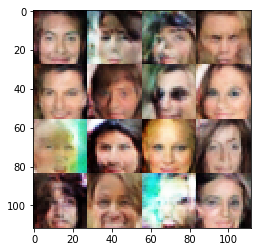

Epoch 1/2 steps 2910... Discriminator Loss: 1.0198... Generator Loss: 1.0601
Epoch 1/2 steps 2920... Discriminator Loss: 1.0194... Generator Loss: 1.0195
Epoch 1/2 steps 2930... Discriminator Loss: 1.2323... Generator Loss: 0.8102
Epoch 1/2 steps 2940... Discriminator Loss: 1.1534... Generator Loss: 0.7824
Epoch 1/2 steps 2950... Discriminator Loss: 1.0914... Generator Loss: 1.2516
Epoch 1/2 steps 2960... Discriminator Loss: 1.1664... Generator Loss: 0.9072
Epoch 1/2 steps 2970... Discriminator Loss: 1.1767... Generator Loss: 1.3647
Epoch 1/2 steps 2980... Discriminator Loss: 1.2358... Generator Loss: 0.8564
Epoch 1/2 steps 2990... Discriminator Loss: 1.1536... Generator Loss: 0.9108
Epoch 1/2 steps 3000... Discriminator Loss: 1.1779... Generator Loss: 0.7957


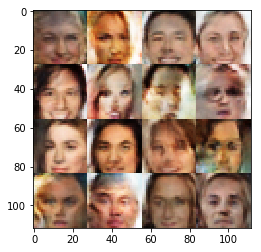

Epoch 1/2 steps 3010... Discriminator Loss: 1.2037... Generator Loss: 0.8824
Epoch 1/2 steps 3020... Discriminator Loss: 0.9991... Generator Loss: 1.1831
Epoch 1/2 steps 3030... Discriminator Loss: 1.1994... Generator Loss: 0.7701
Epoch 1/2 steps 3040... Discriminator Loss: 1.0805... Generator Loss: 1.4021
Epoch 1/2 steps 3050... Discriminator Loss: 0.9765... Generator Loss: 1.0590
Epoch 1/2 steps 3060... Discriminator Loss: 1.2138... Generator Loss: 0.6719
Epoch 1/2 steps 3070... Discriminator Loss: 1.0438... Generator Loss: 0.9601
Epoch 1/2 steps 3080... Discriminator Loss: 1.0462... Generator Loss: 1.1474
Epoch 1/2 steps 3090... Discriminator Loss: 1.1543... Generator Loss: 1.0859
Epoch 1/2 steps 3100... Discriminator Loss: 1.3018... Generator Loss: 0.7475


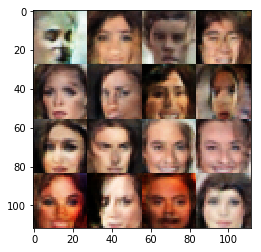

Epoch 1/2 steps 3110... Discriminator Loss: 1.1877... Generator Loss: 1.2334
Epoch 1/2 steps 3120... Discriminator Loss: 1.2660... Generator Loss: 0.9357
Epoch 1/2 steps 3130... Discriminator Loss: 1.2801... Generator Loss: 0.9583
Epoch 1/2 steps 3140... Discriminator Loss: 1.1763... Generator Loss: 0.7843
Epoch 1/2 steps 3150... Discriminator Loss: 1.1445... Generator Loss: 1.1632
Epoch 1/2 steps 3160... Discriminator Loss: 0.9677... Generator Loss: 1.3123
Epoch 2/2 steps 3170... Discriminator Loss: 1.1280... Generator Loss: 0.8957
Epoch 2/2 steps 3180... Discriminator Loss: 1.1087... Generator Loss: 1.2097
Epoch 2/2 steps 3190... Discriminator Loss: 1.2685... Generator Loss: 0.9484
Epoch 2/2 steps 3200... Discriminator Loss: 1.1792... Generator Loss: 0.8568


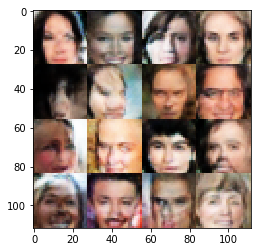

Epoch 2/2 steps 3210... Discriminator Loss: 1.2022... Generator Loss: 0.8347
Epoch 2/2 steps 3220... Discriminator Loss: 1.3563... Generator Loss: 0.7821
Epoch 2/2 steps 3230... Discriminator Loss: 1.4027... Generator Loss: 0.6150
Epoch 2/2 steps 3240... Discriminator Loss: 1.2309... Generator Loss: 0.6497
Epoch 2/2 steps 3250... Discriminator Loss: 1.0985... Generator Loss: 0.9445
Epoch 2/2 steps 3260... Discriminator Loss: 1.1412... Generator Loss: 0.9477
Epoch 2/2 steps 3270... Discriminator Loss: 1.2484... Generator Loss: 0.9737
Epoch 2/2 steps 3280... Discriminator Loss: 1.1529... Generator Loss: 0.8230
Epoch 2/2 steps 3290... Discriminator Loss: 1.1464... Generator Loss: 1.4233
Epoch 2/2 steps 3300... Discriminator Loss: 1.2607... Generator Loss: 0.7304


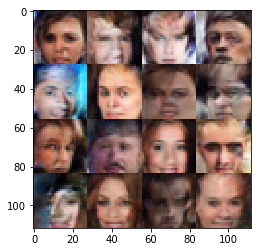

Epoch 2/2 steps 3310... Discriminator Loss: 1.0992... Generator Loss: 1.1167
Epoch 2/2 steps 3320... Discriminator Loss: 1.2174... Generator Loss: 0.7142
Epoch 2/2 steps 3330... Discriminator Loss: 1.1986... Generator Loss: 0.8158
Epoch 2/2 steps 3340... Discriminator Loss: 1.2139... Generator Loss: 0.8489
Epoch 2/2 steps 3350... Discriminator Loss: 1.1262... Generator Loss: 0.9521
Epoch 2/2 steps 3360... Discriminator Loss: 1.1555... Generator Loss: 0.9967
Epoch 2/2 steps 3370... Discriminator Loss: 1.2981... Generator Loss: 0.7501
Epoch 2/2 steps 3380... Discriminator Loss: 1.3012... Generator Loss: 1.0550
Epoch 2/2 steps 3390... Discriminator Loss: 1.4871... Generator Loss: 0.5873
Epoch 2/2 steps 3400... Discriminator Loss: 1.3351... Generator Loss: 1.1355


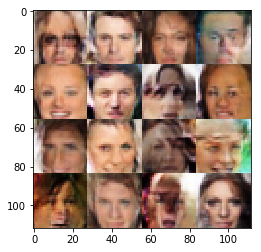

Epoch 2/2 steps 3410... Discriminator Loss: 1.1282... Generator Loss: 1.1534
Epoch 2/2 steps 3420... Discriminator Loss: 1.2357... Generator Loss: 0.8782
Epoch 2/2 steps 3430... Discriminator Loss: 1.2691... Generator Loss: 0.9507
Epoch 2/2 steps 3440... Discriminator Loss: 1.1152... Generator Loss: 0.9194
Epoch 2/2 steps 3450... Discriminator Loss: 0.9958... Generator Loss: 1.1748
Epoch 2/2 steps 3460... Discriminator Loss: 1.1496... Generator Loss: 0.6817
Epoch 2/2 steps 3470... Discriminator Loss: 1.2748... Generator Loss: 0.7947
Epoch 2/2 steps 3480... Discriminator Loss: 1.0815... Generator Loss: 1.0545
Epoch 2/2 steps 3490... Discriminator Loss: 1.2089... Generator Loss: 0.8700
Epoch 2/2 steps 3500... Discriminator Loss: 1.1686... Generator Loss: 0.7143


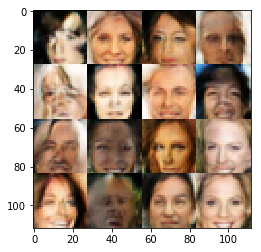

Epoch 2/2 steps 3510... Discriminator Loss: 1.2819... Generator Loss: 0.7244
Epoch 2/2 steps 3520... Discriminator Loss: 1.0453... Generator Loss: 1.0619
Epoch 2/2 steps 3530... Discriminator Loss: 1.1843... Generator Loss: 0.6948
Epoch 2/2 steps 3540... Discriminator Loss: 1.0614... Generator Loss: 1.0827
Epoch 2/2 steps 3550... Discriminator Loss: 1.1327... Generator Loss: 0.7943
Epoch 2/2 steps 3560... Discriminator Loss: 1.3015... Generator Loss: 0.6556
Epoch 2/2 steps 3570... Discriminator Loss: 1.1210... Generator Loss: 0.8642
Epoch 2/2 steps 3580... Discriminator Loss: 1.1829... Generator Loss: 0.7866
Epoch 2/2 steps 3590... Discriminator Loss: 1.6120... Generator Loss: 0.6728
Epoch 2/2 steps 3600... Discriminator Loss: 1.0474... Generator Loss: 1.0011


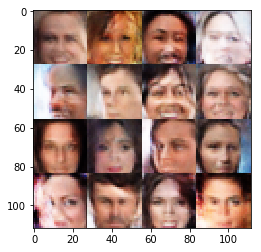

Epoch 2/2 steps 3610... Discriminator Loss: 1.1436... Generator Loss: 0.9453
Epoch 2/2 steps 3620... Discriminator Loss: 1.2507... Generator Loss: 0.8846
Epoch 2/2 steps 3630... Discriminator Loss: 0.9992... Generator Loss: 1.0152
Epoch 2/2 steps 3640... Discriminator Loss: 1.0180... Generator Loss: 1.0966
Epoch 2/2 steps 3650... Discriminator Loss: 0.9576... Generator Loss: 1.0201
Epoch 2/2 steps 3660... Discriminator Loss: 1.1621... Generator Loss: 0.9746
Epoch 2/2 steps 3670... Discriminator Loss: 1.1466... Generator Loss: 0.9079
Epoch 2/2 steps 3680... Discriminator Loss: 1.1865... Generator Loss: 0.8759
Epoch 2/2 steps 3690... Discriminator Loss: 1.2145... Generator Loss: 0.9349
Epoch 2/2 steps 3700... Discriminator Loss: 1.1349... Generator Loss: 0.7544


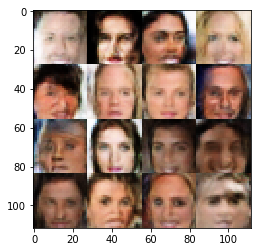

Epoch 2/2 steps 3710... Discriminator Loss: 1.0599... Generator Loss: 1.1159
Epoch 2/2 steps 3720... Discriminator Loss: 1.1712... Generator Loss: 0.8635
Epoch 2/2 steps 3730... Discriminator Loss: 1.3901... Generator Loss: 0.7051
Epoch 2/2 steps 3740... Discriminator Loss: 1.1740... Generator Loss: 0.8435
Epoch 2/2 steps 3750... Discriminator Loss: 0.9667... Generator Loss: 1.1387
Epoch 2/2 steps 3760... Discriminator Loss: 1.0280... Generator Loss: 0.8850
Epoch 2/2 steps 3770... Discriminator Loss: 1.0683... Generator Loss: 1.1666
Epoch 2/2 steps 3780... Discriminator Loss: 1.1917... Generator Loss: 0.9225
Epoch 2/2 steps 3790... Discriminator Loss: 1.3400... Generator Loss: 0.6299
Epoch 2/2 steps 3800... Discriminator Loss: 1.1574... Generator Loss: 1.0575


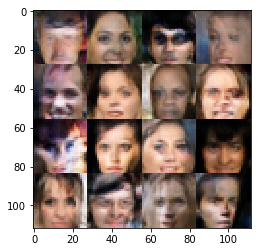

Epoch 2/2 steps 3810... Discriminator Loss: 1.2914... Generator Loss: 0.6433
Epoch 2/2 steps 3820... Discriminator Loss: 1.4247... Generator Loss: 0.4903
Epoch 2/2 steps 3830... Discriminator Loss: 1.2465... Generator Loss: 0.8144
Epoch 2/2 steps 3840... Discriminator Loss: 1.0567... Generator Loss: 0.9308
Epoch 2/2 steps 3850... Discriminator Loss: 1.1647... Generator Loss: 1.1864
Epoch 2/2 steps 3860... Discriminator Loss: 1.1027... Generator Loss: 0.8457
Epoch 2/2 steps 3870... Discriminator Loss: 1.1161... Generator Loss: 0.7883
Epoch 2/2 steps 3880... Discriminator Loss: 1.2518... Generator Loss: 1.3636
Epoch 2/2 steps 3890... Discriminator Loss: 0.9586... Generator Loss: 1.3723
Epoch 2/2 steps 3900... Discriminator Loss: 1.1972... Generator Loss: 0.8216


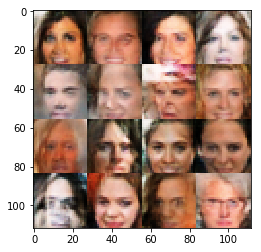

Epoch 2/2 steps 3910... Discriminator Loss: 1.1012... Generator Loss: 0.9587
Epoch 2/2 steps 3920... Discriminator Loss: 1.1631... Generator Loss: 0.7778
Epoch 2/2 steps 3930... Discriminator Loss: 0.9118... Generator Loss: 1.5606
Epoch 2/2 steps 3940... Discriminator Loss: 1.1338... Generator Loss: 0.8059
Epoch 2/2 steps 3950... Discriminator Loss: 1.1373... Generator Loss: 1.0350
Epoch 2/2 steps 3960... Discriminator Loss: 1.1781... Generator Loss: 1.0877
Epoch 2/2 steps 3970... Discriminator Loss: 1.2793... Generator Loss: 0.7342
Epoch 2/2 steps 3980... Discriminator Loss: 1.4750... Generator Loss: 0.7252
Epoch 2/2 steps 3990... Discriminator Loss: 0.9306... Generator Loss: 1.2273
Epoch 2/2 steps 4000... Discriminator Loss: 1.1109... Generator Loss: 1.0339


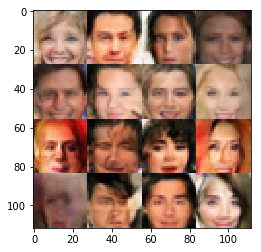

Epoch 2/2 steps 4010... Discriminator Loss: 1.1058... Generator Loss: 1.1676
Epoch 2/2 steps 4020... Discriminator Loss: 1.0853... Generator Loss: 1.2642
Epoch 2/2 steps 4030... Discriminator Loss: 1.1713... Generator Loss: 0.8056
Epoch 2/2 steps 4040... Discriminator Loss: 1.4378... Generator Loss: 0.9374
Epoch 2/2 steps 4050... Discriminator Loss: 1.4232... Generator Loss: 0.5958
Epoch 2/2 steps 4060... Discriminator Loss: 1.3511... Generator Loss: 0.9870
Epoch 2/2 steps 4070... Discriminator Loss: 1.1869... Generator Loss: 0.8863
Epoch 2/2 steps 4080... Discriminator Loss: 1.3152... Generator Loss: 1.1701
Epoch 2/2 steps 4090... Discriminator Loss: 1.1391... Generator Loss: 0.8027
Epoch 2/2 steps 4100... Discriminator Loss: 1.3611... Generator Loss: 0.7167


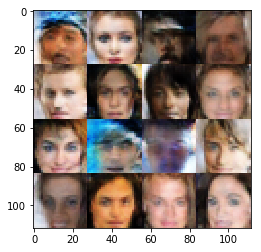

Epoch 2/2 steps 4110... Discriminator Loss: 1.1001... Generator Loss: 0.9810
Epoch 2/2 steps 4120... Discriminator Loss: 1.3619... Generator Loss: 0.6607
Epoch 2/2 steps 4130... Discriminator Loss: 1.2064... Generator Loss: 0.7363
Epoch 2/2 steps 4140... Discriminator Loss: 1.2145... Generator Loss: 0.9509
Epoch 2/2 steps 4150... Discriminator Loss: 1.2137... Generator Loss: 0.9258
Epoch 2/2 steps 4160... Discriminator Loss: 1.2480... Generator Loss: 0.6235
Epoch 2/2 steps 4170... Discriminator Loss: 1.0257... Generator Loss: 1.3207
Epoch 2/2 steps 4180... Discriminator Loss: 1.0086... Generator Loss: 1.0145
Epoch 2/2 steps 4190... Discriminator Loss: 1.2408... Generator Loss: 0.6729
Epoch 2/2 steps 4200... Discriminator Loss: 1.2492... Generator Loss: 0.7142


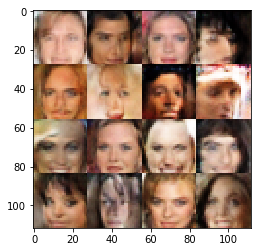

Epoch 2/2 steps 4210... Discriminator Loss: 1.0720... Generator Loss: 1.0481
Epoch 2/2 steps 4220... Discriminator Loss: 1.2590... Generator Loss: 0.9260
Epoch 2/2 steps 4230... Discriminator Loss: 1.1805... Generator Loss: 0.8104
Epoch 2/2 steps 4240... Discriminator Loss: 1.2105... Generator Loss: 0.7481
Epoch 2/2 steps 4250... Discriminator Loss: 1.2414... Generator Loss: 1.5997
Epoch 2/2 steps 4260... Discriminator Loss: 1.5456... Generator Loss: 0.5255
Epoch 2/2 steps 4270... Discriminator Loss: 1.4918... Generator Loss: 0.4785
Epoch 2/2 steps 4280... Discriminator Loss: 1.3976... Generator Loss: 0.5912
Epoch 2/2 steps 4290... Discriminator Loss: 1.1893... Generator Loss: 0.7796
Epoch 2/2 steps 4300... Discriminator Loss: 1.3910... Generator Loss: 0.6172


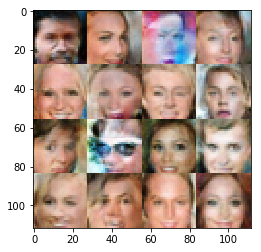

Epoch 2/2 steps 4310... Discriminator Loss: 1.2226... Generator Loss: 0.7592
Epoch 2/2 steps 4320... Discriminator Loss: 1.2117... Generator Loss: 0.9200
Epoch 2/2 steps 4330... Discriminator Loss: 1.2842... Generator Loss: 0.7080
Epoch 2/2 steps 4340... Discriminator Loss: 1.0629... Generator Loss: 0.9698
Epoch 2/2 steps 4350... Discriminator Loss: 1.1754... Generator Loss: 1.1776
Epoch 2/2 steps 4360... Discriminator Loss: 1.2981... Generator Loss: 1.0011
Epoch 2/2 steps 4370... Discriminator Loss: 1.2427... Generator Loss: 1.0561
Epoch 2/2 steps 4380... Discriminator Loss: 1.1838... Generator Loss: 0.9717
Epoch 2/2 steps 4390... Discriminator Loss: 1.1799... Generator Loss: 0.9356
Epoch 2/2 steps 4400... Discriminator Loss: 0.9835... Generator Loss: 1.1349


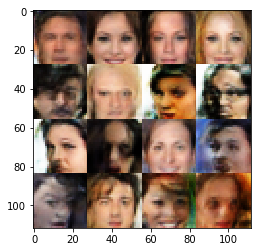

Epoch 2/2 steps 4410... Discriminator Loss: 1.1624... Generator Loss: 1.0355
Epoch 2/2 steps 4420... Discriminator Loss: 1.3334... Generator Loss: 0.5355
Epoch 2/2 steps 4430... Discriminator Loss: 1.2992... Generator Loss: 0.8045
Epoch 2/2 steps 4440... Discriminator Loss: 1.0734... Generator Loss: 0.9372
Epoch 2/2 steps 4450... Discriminator Loss: 0.9982... Generator Loss: 1.4057
Epoch 2/2 steps 4460... Discriminator Loss: 1.0718... Generator Loss: 1.0205
Epoch 2/2 steps 4470... Discriminator Loss: 1.1183... Generator Loss: 1.1510
Epoch 2/2 steps 4480... Discriminator Loss: 0.9987... Generator Loss: 1.3211
Epoch 2/2 steps 4490... Discriminator Loss: 1.1347... Generator Loss: 1.4651
Epoch 2/2 steps 4500... Discriminator Loss: 1.0161... Generator Loss: 1.5012


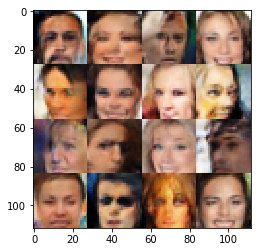

Epoch 2/2 steps 4510... Discriminator Loss: 1.4512... Generator Loss: 0.8782
Epoch 2/2 steps 4520... Discriminator Loss: 1.0741... Generator Loss: 1.2303
Epoch 2/2 steps 4530... Discriminator Loss: 1.1663... Generator Loss: 0.8001
Epoch 2/2 steps 4540... Discriminator Loss: 1.2443... Generator Loss: 1.5778
Epoch 2/2 steps 4550... Discriminator Loss: 1.1329... Generator Loss: 1.3395
Epoch 2/2 steps 4560... Discriminator Loss: 1.1359... Generator Loss: 0.7902
Epoch 2/2 steps 4570... Discriminator Loss: 1.3113... Generator Loss: 1.1500
Epoch 2/2 steps 4580... Discriminator Loss: 1.0452... Generator Loss: 1.3605
Epoch 2/2 steps 4590... Discriminator Loss: 1.1137... Generator Loss: 1.2486
Epoch 2/2 steps 4600... Discriminator Loss: 1.3205... Generator Loss: 0.7944


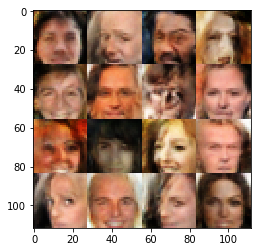

Epoch 2/2 steps 4610... Discriminator Loss: 1.1968... Generator Loss: 0.6843
Epoch 2/2 steps 4620... Discriminator Loss: 1.1906... Generator Loss: 0.9237
Epoch 2/2 steps 4630... Discriminator Loss: 1.0327... Generator Loss: 1.1469
Epoch 2/2 steps 4640... Discriminator Loss: 1.5010... Generator Loss: 0.5603
Epoch 2/2 steps 4650... Discriminator Loss: 1.1270... Generator Loss: 1.1305
Epoch 2/2 steps 4660... Discriminator Loss: 1.2781... Generator Loss: 0.7395
Epoch 2/2 steps 4670... Discriminator Loss: 1.3142... Generator Loss: 0.7818
Epoch 2/2 steps 4680... Discriminator Loss: 1.0370... Generator Loss: 0.9337
Epoch 2/2 steps 4690... Discriminator Loss: 1.2538... Generator Loss: 1.0426
Epoch 2/2 steps 4700... Discriminator Loss: 1.0822... Generator Loss: 1.1950


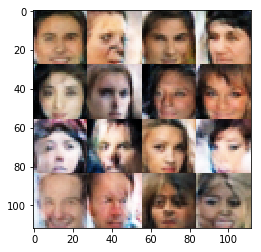

Epoch 2/2 steps 4710... Discriminator Loss: 1.1428... Generator Loss: 0.8909
Epoch 2/2 steps 4720... Discriminator Loss: 1.2147... Generator Loss: 0.7177
Epoch 2/2 steps 4730... Discriminator Loss: 1.1449... Generator Loss: 1.0345
Epoch 2/2 steps 4740... Discriminator Loss: 1.2621... Generator Loss: 0.7962
Epoch 2/2 steps 4750... Discriminator Loss: 1.2969... Generator Loss: 0.7333
Epoch 2/2 steps 4760... Discriminator Loss: 1.2709... Generator Loss: 0.8295
Epoch 2/2 steps 4770... Discriminator Loss: 1.1080... Generator Loss: 1.2215
Epoch 2/2 steps 4780... Discriminator Loss: 1.2559... Generator Loss: 1.0057
Epoch 2/2 steps 4790... Discriminator Loss: 1.2985... Generator Loss: 0.7150
Epoch 2/2 steps 4800... Discriminator Loss: 1.1793... Generator Loss: 0.8286


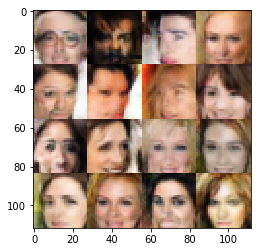

Epoch 2/2 steps 4810... Discriminator Loss: 1.2452... Generator Loss: 0.7960
Epoch 2/2 steps 4820... Discriminator Loss: 1.2201... Generator Loss: 0.7709
Epoch 2/2 steps 4830... Discriminator Loss: 1.2618... Generator Loss: 1.0068
Epoch 2/2 steps 4840... Discriminator Loss: 1.2494... Generator Loss: 0.8082
Epoch 2/2 steps 4850... Discriminator Loss: 1.2028... Generator Loss: 1.0701
Epoch 2/2 steps 4860... Discriminator Loss: 1.3673... Generator Loss: 0.6687
Epoch 2/2 steps 4870... Discriminator Loss: 1.1535... Generator Loss: 0.8585
Epoch 2/2 steps 4880... Discriminator Loss: 1.1412... Generator Loss: 1.3498
Epoch 2/2 steps 4890... Discriminator Loss: 1.1258... Generator Loss: 1.2803
Epoch 2/2 steps 4900... Discriminator Loss: 1.3643... Generator Loss: 0.6893


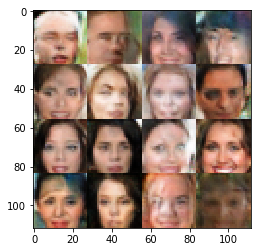

Epoch 2/2 steps 4910... Discriminator Loss: 1.1173... Generator Loss: 1.0070
Epoch 2/2 steps 4920... Discriminator Loss: 1.1566... Generator Loss: 0.8901
Epoch 2/2 steps 4930... Discriminator Loss: 1.1858... Generator Loss: 0.9906
Epoch 2/2 steps 4940... Discriminator Loss: 1.3148... Generator Loss: 0.9380
Epoch 2/2 steps 4950... Discriminator Loss: 1.3348... Generator Loss: 0.9068
Epoch 2/2 steps 4960... Discriminator Loss: 1.2009... Generator Loss: 0.8847
Epoch 2/2 steps 4970... Discriminator Loss: 1.1980... Generator Loss: 0.7396
Epoch 2/2 steps 4980... Discriminator Loss: 1.2552... Generator Loss: 0.7030
Epoch 2/2 steps 4990... Discriminator Loss: 1.2698... Generator Loss: 0.8030
Epoch 2/2 steps 5000... Discriminator Loss: 1.1065... Generator Loss: 1.0978


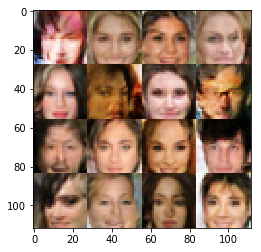

Epoch 2/2 steps 5010... Discriminator Loss: 1.0321... Generator Loss: 1.3038
Epoch 2/2 steps 5020... Discriminator Loss: 1.1091... Generator Loss: 0.8406
Epoch 2/2 steps 5030... Discriminator Loss: 1.2034... Generator Loss: 0.9367
Epoch 2/2 steps 5040... Discriminator Loss: 1.1354... Generator Loss: 0.9540
Epoch 2/2 steps 5050... Discriminator Loss: 1.2544... Generator Loss: 0.8571
Epoch 2/2 steps 5060... Discriminator Loss: 1.3793... Generator Loss: 0.5203
Epoch 2/2 steps 5070... Discriminator Loss: 1.1211... Generator Loss: 0.7709
Epoch 2/2 steps 5080... Discriminator Loss: 1.0923... Generator Loss: 0.8440
Epoch 2/2 steps 5090... Discriminator Loss: 1.1688... Generator Loss: 1.3829
Epoch 2/2 steps 5100... Discriminator Loss: 1.4802... Generator Loss: 0.6005


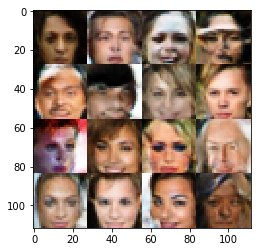

Epoch 2/2 steps 5110... Discriminator Loss: 1.0368... Generator Loss: 1.0383
Epoch 2/2 steps 5120... Discriminator Loss: 1.2720... Generator Loss: 0.9901
Epoch 2/2 steps 5130... Discriminator Loss: 1.4018... Generator Loss: 0.6105
Epoch 2/2 steps 5140... Discriminator Loss: 1.4343... Generator Loss: 0.5215
Epoch 2/2 steps 5150... Discriminator Loss: 1.1380... Generator Loss: 0.9597
Epoch 2/2 steps 5160... Discriminator Loss: 1.2616... Generator Loss: 0.8979
Epoch 2/2 steps 5170... Discriminator Loss: 1.3574... Generator Loss: 0.6479
Epoch 2/2 steps 5180... Discriminator Loss: 1.1872... Generator Loss: 0.8901
Epoch 2/2 steps 5190... Discriminator Loss: 1.5175... Generator Loss: 0.5227
Epoch 2/2 steps 5200... Discriminator Loss: 0.9646... Generator Loss: 1.0018


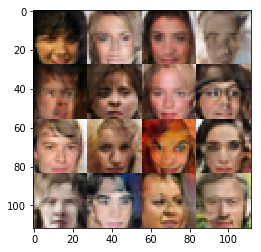

Epoch 2/2 steps 5210... Discriminator Loss: 1.2625... Generator Loss: 0.8754
Epoch 2/2 steps 5220... Discriminator Loss: 1.2619... Generator Loss: 1.3471
Epoch 2/2 steps 5230... Discriminator Loss: 1.2268... Generator Loss: 0.9114
Epoch 2/2 steps 5240... Discriminator Loss: 1.2829... Generator Loss: 1.2105
Epoch 2/2 steps 5250... Discriminator Loss: 1.3703... Generator Loss: 0.6059
Epoch 2/2 steps 5260... Discriminator Loss: 1.2310... Generator Loss: 0.9765
Epoch 2/2 steps 5270... Discriminator Loss: 1.0831... Generator Loss: 0.9652
Epoch 2/2 steps 5280... Discriminator Loss: 1.5707... Generator Loss: 0.5896
Epoch 2/2 steps 5290... Discriminator Loss: 1.1383... Generator Loss: 1.0241
Epoch 2/2 steps 5300... Discriminator Loss: 1.2725... Generator Loss: 0.7409


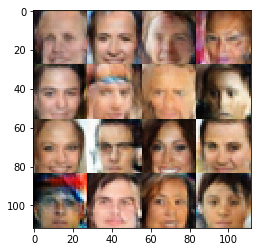

Epoch 2/2 steps 5310... Discriminator Loss: 1.0790... Generator Loss: 1.2659
Epoch 2/2 steps 5320... Discriminator Loss: 1.1992... Generator Loss: 0.8635
Epoch 2/2 steps 5330... Discriminator Loss: 1.1021... Generator Loss: 1.0283
Epoch 2/2 steps 5340... Discriminator Loss: 1.1746... Generator Loss: 1.0426
Epoch 2/2 steps 5350... Discriminator Loss: 1.2733... Generator Loss: 0.6744
Epoch 2/2 steps 5360... Discriminator Loss: 1.1792... Generator Loss: 0.9798
Epoch 2/2 steps 5370... Discriminator Loss: 0.9795... Generator Loss: 1.2703
Epoch 2/2 steps 5380... Discriminator Loss: 1.1275... Generator Loss: 0.8107
Epoch 2/2 steps 5390... Discriminator Loss: 1.5197... Generator Loss: 0.5369
Epoch 2/2 steps 5400... Discriminator Loss: 0.9765... Generator Loss: 1.1632


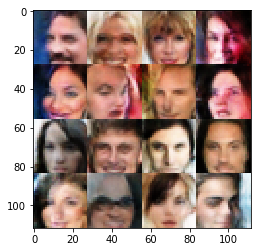

Epoch 2/2 steps 5410... Discriminator Loss: 1.2333... Generator Loss: 0.8556
Epoch 2/2 steps 5420... Discriminator Loss: 1.1477... Generator Loss: 0.7917
Epoch 2/2 steps 5430... Discriminator Loss: 1.4135... Generator Loss: 0.6454
Epoch 2/2 steps 5440... Discriminator Loss: 1.2454... Generator Loss: 0.7780
Epoch 2/2 steps 5450... Discriminator Loss: 1.1450... Generator Loss: 1.1659
Epoch 2/2 steps 5460... Discriminator Loss: 1.0292... Generator Loss: 1.0506
Epoch 2/2 steps 5470... Discriminator Loss: 1.3440... Generator Loss: 0.7439
Epoch 2/2 steps 5480... Discriminator Loss: 1.4493... Generator Loss: 0.6030
Epoch 2/2 steps 5490... Discriminator Loss: 1.0793... Generator Loss: 0.9966
Epoch 2/2 steps 5500... Discriminator Loss: 1.1490... Generator Loss: 1.1777


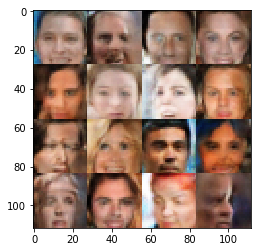

Epoch 2/2 steps 5510... Discriminator Loss: 1.0296... Generator Loss: 1.3205
Epoch 2/2 steps 5520... Discriminator Loss: 1.0011... Generator Loss: 1.1333
Epoch 2/2 steps 5530... Discriminator Loss: 1.3323... Generator Loss: 0.9453
Epoch 2/2 steps 5540... Discriminator Loss: 1.1795... Generator Loss: 0.8236
Epoch 2/2 steps 5550... Discriminator Loss: 1.2055... Generator Loss: 1.0050
Epoch 2/2 steps 5560... Discriminator Loss: 1.3477... Generator Loss: 0.6703
Epoch 2/2 steps 5570... Discriminator Loss: 1.3292... Generator Loss: 0.6035
Epoch 2/2 steps 5580... Discriminator Loss: 1.1428... Generator Loss: 1.4514
Epoch 2/2 steps 5590... Discriminator Loss: 1.1440... Generator Loss: 1.1464
Epoch 2/2 steps 5600... Discriminator Loss: 1.3992... Generator Loss: 0.5708


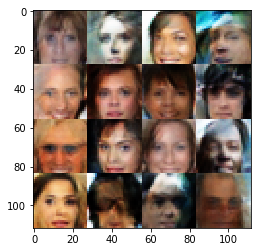

Epoch 2/2 steps 5610... Discriminator Loss: 1.2993... Generator Loss: 1.2409
Epoch 2/2 steps 5620... Discriminator Loss: 1.2737... Generator Loss: 0.8486
Epoch 2/2 steps 5630... Discriminator Loss: 1.0622... Generator Loss: 1.1643
Epoch 2/2 steps 5640... Discriminator Loss: 0.9520... Generator Loss: 1.3096
Epoch 2/2 steps 5650... Discriminator Loss: 1.1375... Generator Loss: 0.8206
Epoch 2/2 steps 5660... Discriminator Loss: 1.1830... Generator Loss: 0.9085
Epoch 2/2 steps 5670... Discriminator Loss: 1.2007... Generator Loss: 0.8521
Epoch 2/2 steps 5680... Discriminator Loss: 0.9729... Generator Loss: 1.3016
Epoch 2/2 steps 5690... Discriminator Loss: 1.2236... Generator Loss: 1.2296
Epoch 2/2 steps 5700... Discriminator Loss: 0.9801... Generator Loss: 1.4521


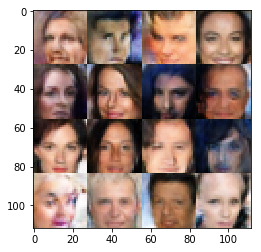

Epoch 2/2 steps 5710... Discriminator Loss: 1.1344... Generator Loss: 0.8894
Epoch 2/2 steps 5720... Discriminator Loss: 1.3512... Generator Loss: 0.8031
Epoch 2/2 steps 5730... Discriminator Loss: 1.1608... Generator Loss: 0.7206
Epoch 2/2 steps 5740... Discriminator Loss: 1.2342... Generator Loss: 0.6477
Epoch 2/2 steps 5750... Discriminator Loss: 1.1915... Generator Loss: 0.8104
Epoch 2/2 steps 5760... Discriminator Loss: 1.3083... Generator Loss: 0.7464
Epoch 2/2 steps 5770... Discriminator Loss: 1.1159... Generator Loss: 0.9617
Epoch 2/2 steps 5780... Discriminator Loss: 1.2452... Generator Loss: 0.7635
Epoch 2/2 steps 5790... Discriminator Loss: 1.0899... Generator Loss: 0.8789
Epoch 2/2 steps 5800... Discriminator Loss: 1.2477... Generator Loss: 0.8259


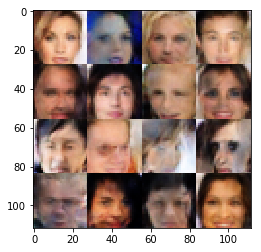

Epoch 2/2 steps 5810... Discriminator Loss: 1.2931... Generator Loss: 0.8013
Epoch 2/2 steps 5820... Discriminator Loss: 0.9382... Generator Loss: 1.2092
Epoch 2/2 steps 5830... Discriminator Loss: 1.2665... Generator Loss: 0.6770
Epoch 2/2 steps 5840... Discriminator Loss: 1.0389... Generator Loss: 1.0537
Epoch 2/2 steps 5850... Discriminator Loss: 1.4245... Generator Loss: 0.6728
Epoch 2/2 steps 5860... Discriminator Loss: 1.1125... Generator Loss: 1.2546
Epoch 2/2 steps 5870... Discriminator Loss: 1.3409... Generator Loss: 0.6941
Epoch 2/2 steps 5880... Discriminator Loss: 1.2032... Generator Loss: 1.2270
Epoch 2/2 steps 5890... Discriminator Loss: 1.1062... Generator Loss: 1.0635
Epoch 2/2 steps 5900... Discriminator Loss: 1.2690... Generator Loss: 0.9446


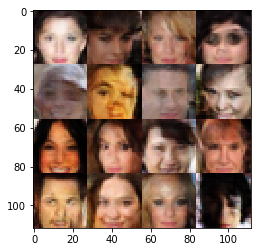

Epoch 2/2 steps 5910... Discriminator Loss: 1.1714... Generator Loss: 0.8138
Epoch 2/2 steps 5920... Discriminator Loss: 1.2037... Generator Loss: 0.9119
Epoch 2/2 steps 5930... Discriminator Loss: 1.2738... Generator Loss: 1.3838
Epoch 2/2 steps 5940... Discriminator Loss: 1.2591... Generator Loss: 0.6150
Epoch 2/2 steps 5950... Discriminator Loss: 1.1089... Generator Loss: 0.8486
Epoch 2/2 steps 5960... Discriminator Loss: 1.1121... Generator Loss: 1.3459
Epoch 2/2 steps 5970... Discriminator Loss: 1.5751... Generator Loss: 0.4769
Epoch 2/2 steps 5980... Discriminator Loss: 1.1803... Generator Loss: 0.7913
Epoch 2/2 steps 5990... Discriminator Loss: 1.2100... Generator Loss: 0.7837
Epoch 2/2 steps 6000... Discriminator Loss: 1.2098... Generator Loss: 0.9767


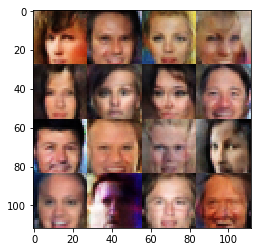

Epoch 2/2 steps 6010... Discriminator Loss: 1.1927... Generator Loss: 1.0042
Epoch 2/2 steps 6020... Discriminator Loss: 1.2360... Generator Loss: 0.7084
Epoch 2/2 steps 6030... Discriminator Loss: 1.0120... Generator Loss: 1.0433
Epoch 2/2 steps 6040... Discriminator Loss: 1.1442... Generator Loss: 0.9580
Epoch 2/2 steps 6050... Discriminator Loss: 1.2942... Generator Loss: 0.7618
Epoch 2/2 steps 6060... Discriminator Loss: 1.4292... Generator Loss: 0.5596
Epoch 2/2 steps 6070... Discriminator Loss: 1.2153... Generator Loss: 0.8563
Epoch 2/2 steps 6080... Discriminator Loss: 1.1784... Generator Loss: 0.8297
Epoch 2/2 steps 6090... Discriminator Loss: 1.1972... Generator Loss: 0.8352
Epoch 2/2 steps 6100... Discriminator Loss: 1.2230... Generator Loss: 1.3177


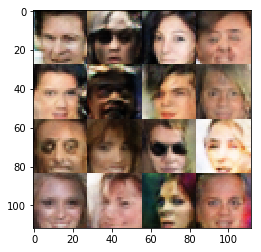

Epoch 2/2 steps 6110... Discriminator Loss: 1.0104... Generator Loss: 1.1327
Epoch 2/2 steps 6120... Discriminator Loss: 1.3245... Generator Loss: 0.7633
Epoch 2/2 steps 6130... Discriminator Loss: 1.1344... Generator Loss: 0.9725
Epoch 2/2 steps 6140... Discriminator Loss: 1.2143... Generator Loss: 0.8190
Epoch 2/2 steps 6150... Discriminator Loss: 1.2775... Generator Loss: 0.7793
Epoch 2/2 steps 6160... Discriminator Loss: 1.1528... Generator Loss: 0.9270
Epoch 2/2 steps 6170... Discriminator Loss: 1.0586... Generator Loss: 1.0877
Epoch 2/2 steps 6180... Discriminator Loss: 1.1604... Generator Loss: 1.2611
Epoch 2/2 steps 6190... Discriminator Loss: 1.0434... Generator Loss: 1.0313
Epoch 2/2 steps 6200... Discriminator Loss: 1.0193... Generator Loss: 1.4129


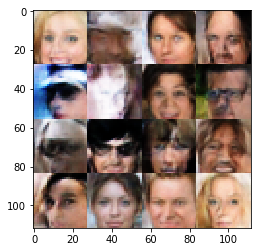

Epoch 2/2 steps 6210... Discriminator Loss: 1.1776... Generator Loss: 0.8868
Epoch 2/2 steps 6220... Discriminator Loss: 1.1350... Generator Loss: 0.8954
Epoch 2/2 steps 6230... Discriminator Loss: 1.2636... Generator Loss: 0.6698
Epoch 2/2 steps 6240... Discriminator Loss: 1.0461... Generator Loss: 1.3017
Epoch 2/2 steps 6250... Discriminator Loss: 1.3557... Generator Loss: 0.5650
Epoch 2/2 steps 6260... Discriminator Loss: 1.1227... Generator Loss: 0.9088
Epoch 2/2 steps 6270... Discriminator Loss: 1.1839... Generator Loss: 1.1039
Epoch 2/2 steps 6280... Discriminator Loss: 1.1445... Generator Loss: 0.8063
Epoch 2/2 steps 6290... Discriminator Loss: 1.0797... Generator Loss: 0.9595
Epoch 2/2 steps 6300... Discriminator Loss: 1.2952... Generator Loss: 0.7498


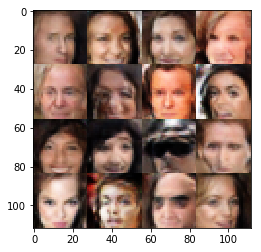

Epoch 2/2 steps 6310... Discriminator Loss: 1.0544... Generator Loss: 0.9982
Epoch 2/2 steps 6320... Discriminator Loss: 1.3099... Generator Loss: 0.7797
Epoch 2/2 steps 6330... Discriminator Loss: 1.0707... Generator Loss: 1.0559
end of loop
about to exit train()
done training celeba
done-tf.graph
done celeba_dataset (202599, 28, 28, 3)RGB


In [27]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)
    print("done training celeba")
print("done-tf.graph")

print("done celeba_dataset {}{}".format(celeba_dataset.shape, celeba_dataset.image_mode))


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.